**<center>Universidad ITESO:
Programación para Minería de Datos
Unidad 4 – Gran N </center>**

![image.png](https://tse4.mm.bing.net/th/id/OIP.BPZIFt6DQ_3b-PcBqbrGIAHaDD?cb=12&rs=1&pid=ImgDetMain&o=7&rm=3)

* **Integrantes:** Karen Elizabeth González Santana, Francisco Javier Ramos Jiménez, Josué Godoy Orozco, Néstor Eduardo Pérez Avalos.
* **Fecha:** 19 de octubre, 2025.

Objetivo: Limpar, escalar e imputar dataset.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


In [5]:
df_original = pd.read_excel('../CSVs/DataSet_Gran_N.xlsx')
df = df_original.copy()

In [6]:
faltantes = df.isna().sum().sort_values(ascending=False)
porcentaje = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
resumen_faltantes = pd.DataFrame({"faltantes": faltantes, "porcentaje_%": porcentaje})
print("\n Resumen de faltantes por columna:\n")
print(resumen_faltantes, "\n")
lista = resumen_faltantes[resumen_faltantes["faltantes"] < 40] # filtrado de columnas con menores a 40% de datos faltantes
np.shape(df)
np.shape(lista)



 Resumen de faltantes por columna:

                            faltantes  porcentaje_%
strike_price                      100         100.0
coupon_save                       100         100.0
details_pocket_description         99          99.0
details_ram                        99          99.0
details_hardware_interface         99          99.0
...                               ...           ...
short_url                           0           0.0
store_title                         0           0.0
image_1                             0           0.0
position                            0           0.0
query                               0           0.0

[126 rows x 2 columns] 



(37, 2)

In [7]:
# Obtener las columnas que cumplen la condición
columnas_filtradas = lista.index

# Crear un nuevo DataFrame excluyendo las columnas con más de 40 faltantes
df_filtrado = df[columnas_filtradas]

# Verificar forma del nuevo DataFrame
print(df_filtrado.shape)
faltantes = df_filtrado.isna().sum().sort_values(ascending=False)
porcentaje = (df_filtrado.isna().mean() * 100).round(2).sort_values(ascending=False)
resumen_faltantes = pd.DataFrame({"faltantes": faltantes, "porcentaje_%": porcentaje})
print("\n Resumen de faltantes por columna:\n")
print(resumen_faltantes, "\n")



(100, 37)

 Resumen de faltantes por columna:

                              faltantes  porcentaje_%
details_product_dimensions           37          37.0
details_item_model_number            32          32.0
merchant_info                        16          16.0
delivery_date                        15          15.0
delivery_price                       15          15.0
image_5                              15          15.0
delivery_date_parsed                 15          15.0
image_4                              13          13.0
image_3                              10          10.0
merchant_url                          9           9.0
details_manufacturer                  7           7.0
image_2                               6           6.0
high_res_images                       6           6.0
details_item_weight                   4           4.0
about                                 3           3.0
details_best_sellers_rank             3           3.0
details_date_first_available       

In [8]:
# Columnas numéricas
numeric_columns = df_filtrado.select_dtypes(include=[np.number]).columns
print(f"Numericas del DF:\n{numeric_columns}")
#Columnads categóricas
categoric_columns = df_filtrado.select_dtypes(include=['object']).columns
print(f"Categóricas del DF:\n{categoric_columns}")

for column in categoric_columns:
    print(f"Columna categórica: {column}")
    print(df[column].unique())
    print("-"*80)


Numericas del DF:
Index(['price_saving', 'reviews', 'rating', 'price_parsed', 'position'], dtype='object')
Categóricas del DF:
Index(['details_product_dimensions', 'details_item_model_number',
       'merchant_info', 'delivery_date', 'delivery_price', 'image_5',
       'delivery_date_parsed', 'image_4', 'image_3', 'merchant_url',
       'details_manufacturer', 'image_2', 'high_res_images',
       'details_item_weight', 'about', 'details_best_sellers_rank',
       'details_date_first_available', 'categories',
       'details_customer_reviews', 'availability', 'currency', 'name',
       'ref_url', 'asin', 'price', 'url', 'store_url', 'short_url',
       'store_title', 'image_1', 'query'],
      dtype='object')
Columna categórica: details_product_dimensions
['8.86 x 8.66 x 4.21 inches; 3.46 Pounds'
 '8.27 x 3.98 x 10.2 inches; 3.17 Pounds'
 '9.4 x 0.55 x 4.01 inches; 1 Pounds'
 '2.9 x 6.5 x 7.9 inches; 2.93 Pounds' '14 x 4 x 8 inches; 3.09 Pounds'
 '8.46 x 4.53 x 0.5 inches' '14 x 8 x 3.5

In [9]:
# Analizando las columnas, y hay redundancia en algunas columnas, también consideramos que las imagenes columnas no son un dato importante para tomar una decision, puesto que es un link.
# Quitamos las columnas categóricas que no aportan información estadística.
df_nuevo = df_filtrado.drop(columns= ["price", "details_customer_reviews", "currency", "image_2", "image_4",'image_3','image_5', 'image_1', 'url', 'store_url', 'short_url', 'ref_url', 'high_res_images', 'asin', 'merchant_url', 'details_best_sellers_rank', 'query', 'about', 'delivery_date_parsed', 'details_product_dimensions', 'details_item_model_number', 'name', 'delivery_price', 'details_date_first_available', 'details_manufacturer', 'merchant_info'])


#La columna availability tiene datos los cuales no podemos procesar tal y como están, entonces estamos cambiando su forma de representarlos.
#para eso vimos el dataset y concluimos que si conteine only se le asigna 'caution, few left' y los demas datos solo available, ya que no
# habia outsale.
df_nuevo['availability'] = df_nuevo['availability'].apply(
    lambda x: 'Caution, few left' if 'only' in str(x).lower() else 'Available'
)

def convert_to_pounds(value):
    if pd.isna(value):
        return np.nan
    value = str(value).replace('\u200e', '').strip().lower()  # limpiar caracteres invisibles
    if 'ounce' in value:
        num = float(value.split()[0])
        return round(num / 16, 3)  # 16 onzas = 1 libra
    elif 'pound' in value:
        num = float(value.split()[0])
        return round(num, 3)
    else:
        return np.nan  # si no tiene unidad reconocida

# Aplicar la conversión
df_nuevo['item_weight_pounds'] = df_nuevo['details_item_weight'].apply(convert_to_pounds)
df_nuevo = df_nuevo.drop(columns=['details_item_weight'])

# Limpiado de store o brand
df_nuevo['store_title'] = df_nuevo['store_title'].apply(
    lambda x: 'Store' if isinstance(x, str) and 'store' in x.lower()
    else ('Brand' if isinstance(x, str) and 'brand' in x.lower() else x)
)

# Limpiado de categorias
'''
Se hizo un filtrado de la columan categories, dejando mas limpia, dejando de opciones 'Switch 2','Switch','3DS','DS','Nintendo 64','Wii U','Accessories'
esto para posteriormente hacerle un encoder de ordinalEncoder esto definido por el producto mas actual.
'''
df_nuevo['categories'] = df_nuevo['categories'].apply(
    lambda x: (
        'Switch 2' if isinstance(x, str) and 'switch 2' in x.lower() else
        'Switch'   if isinstance(x, str) and 'switch' in x.lower() else
        '3DS'      if isinstance(x, str) and '3ds' in x.lower() else
        'DS'       if isinstance(x, str) and 'ds' in x.lower() else
        'Nintendo 64' if isinstance(x, str) and 'nintendo 64' in x.lower() else
        'Wii U'    if isinstance(x, str) and 'wii u' in x.lower() else
        'Accessories'
    )
)


categoric_columns = df_nuevo.select_dtypes(include=['object']).columns
print(f"Categóricas del DF:\n{categoric_columns}")

for column in categoric_columns:
    print(f"Columna categórica: {column}")
    print(df_nuevo[column].unique())
    print("-"*80)

Categóricas del DF:
Index(['delivery_date', 'categories', 'availability', 'store_title'], dtype='object')
Columna categórica: delivery_date
['10/10/2025 00:00:00' nan '10/14/2025 00:00:00' '10/07/2025 00:00:00'
 '10/09/2025 00:00:00' '10/11/2025 00:00:00' '10/08/2025 00:00:00']
--------------------------------------------------------------------------------
Columna categórica: categories
['Switch 2' 'Switch' 'Accessories' 'Nintendo 64' 'DS' 'Wii U' '3DS']
--------------------------------------------------------------------------------
Columna categórica: availability
['Available' 'Caution, few left']
--------------------------------------------------------------------------------
Columna categórica: store_title
['Store' 'Brand']
--------------------------------------------------------------------------------


In [10]:
# Columnas numéricas
numeric_columns = df_nuevo.select_dtypes(include=[np.number]).columns
print(f"Numericas del DF:\n{numeric_columns}")
#Columnads categóricas
categoric_columns = df_nuevo.select_dtypes(include=['object']).columns
print(f"Categóricas del DF:\n{categoric_columns}")

df_nuevo.describe()
X_train, X_test = train_test_split(df_nuevo, test_size=0.25, random_state=0)


Numericas del DF:
Index(['price_saving', 'reviews', 'rating', 'price_parsed', 'position',
       'item_weight_pounds'],
      dtype='object')
Categóricas del DF:
Index(['delivery_date', 'categories', 'availability', 'store_title'], dtype='object')


Columnas numéricas: ['price_saving', 'reviews', 'rating', 'price_parsed', 'position', 'item_weight_pounds']


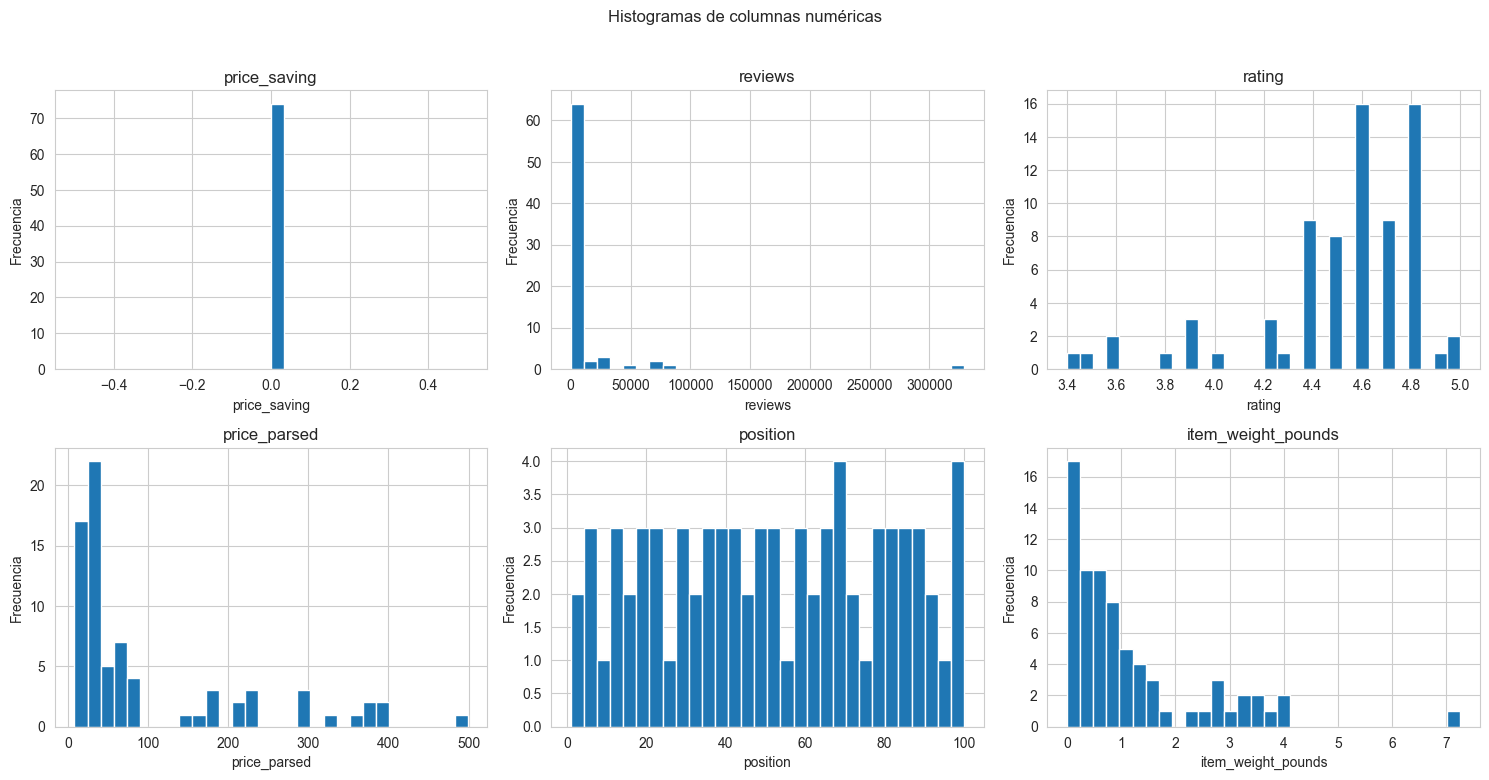

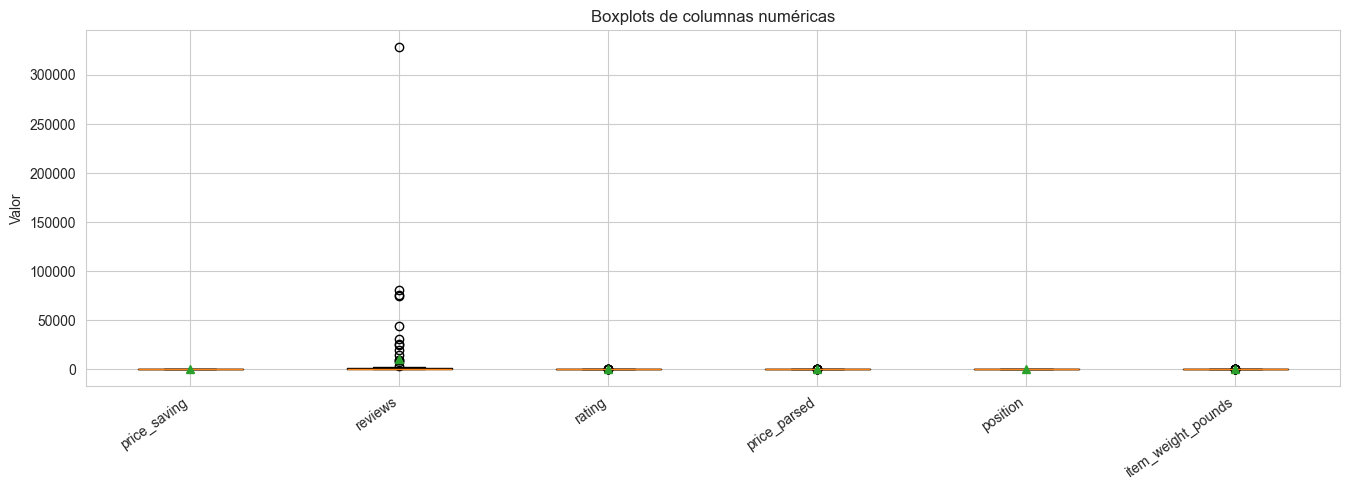

In [11]:
# Separamos las columnas númericas
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas numéricas:", num_cols)

# Funciones auxiliares
# Detection de outliers
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    number_outlier_detected = int(((s < lim_inf) | (s > lim_sup)).sum())
    proportion_outliers_respect_total = number_outlier_detected / len(s)

    return number_outlier_detected, proportion_outliers_respect_total, q1, q3, lim_inf, lim_sup

# Detecta si parece estar acotada en [0,1] o [0,100]
def bounded_guess(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    min_value, max_value = float(s.min()), float(s.max())
    if 0.0 <= min_value and max_value <= 1.0:
        return "[0,1]"
    if 0.0 <= min_value and max_value <= 100.0:
        return "[0,100]"
    return None

if len(num_cols) == 0:
    print("No hay columnas numéricas en X_train.")
else:
    # --------- Histogramas ----------
    n = len(num_cols)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()
    #Aplico Histograma y Box Plot a la parte de Entrenamiento
    for i, col in enumerate(num_cols):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")


    for j in range(len(num_cols), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("../reports/histogramas_numericas.png", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # --------- BOXPLOTS ----------
    series_pairs = []
    for c in num_cols:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("../reports/boxplots_numericas.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig2)


In [12]:
diagnostico = []
for c in num_cols:
    s = pd.to_numeric(X_train[c], errors="coerce")
    number_outlier_detected, proportion_outliers_respect_total, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)
    #Calcula el porcentaje de valores faltantes
    miss_pct = s.isna().mean() * 100
    #Elimina valores faltantes
    s_no_na = s.dropna()
    #Calcula la asimetria de la distribucion
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    #Calcula la curtosis
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan


    if (proportion_outliers_respect_total >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"


    if proportion_outliers_respect_total >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"  # por defecto en casos no normales o acotados

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": number_outlier_detected,
        "outliers_%": round(proportion_outliers_respect_total*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recommended_imputer": imputador,
        "recommended_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%","missing_%"], ascending=False)
print("\n=== Diagnóstico numérico (heurística) ===\n")
# Aumenta el ancho máximo de columnas impresas
pd.set_option('display.width', 1000)

# Permite mostrar más columnas sin truncar
pd.set_option('display.max_columns', None)

# Muestra más filas si lo necesitas
pd.set_option('display.max_rows', None)

# Reinicar el Indice
diag_df = diag_df.reset_index(drop=True)

print(diag_df)

# Sugerencias para columnas numéricas
suggest_mean_rob = diag_df.query("recommended_imputer=='mean' and recommended_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recommended_imputer=='median' and recommended_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recommended_imputer=='median' and recommended_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recommended_imputer=='median' and recommended_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recommended_imputer=='mean' and recommended_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recommended_imputer=='mean' and recommended_scaler=='StandardScaler'")["columna"].tolist()

print("#"*190)
print("\nSugerencias de columnas numéricas")
print("Imputador + Escalador: Selección de Columnas")
print(f"{'median + Robust':<21}: {suggest_med_rob}")
print(f"{'median + MinMax':<21}: {suggest_med_min}")
print(f"{'median + Standard':<21}: {suggest_med_std}")
print(f"{'mean + Robust':<21}: {suggest_mean_rob}")
print(f"{'mean + MinMax':<21}: {suggest_mean_min}")
print(f"{'mean + Standard':<21}: {suggest_mean_std}")


=== Diagnóstico numérico (heurística) ===

              columna  missing_%   skew  kurtosis  outliers_n  outliers_%        q1        q3         IQR      lim_inf      lim_sup  bounded recommended_imputer recommended_scaler
0             reviews       1.33  6.751    51.039          14       18.92  51.25000  1365.250  1314.00000 -1919.750000  3336.250000     None              median       RobustScaler
1  item_weight_pounds       4.00  2.061     5.507           9       12.50   0.29375     1.355     1.06125    -1.298125     2.946875  [0,100]              median       RobustScaler
2        price_parsed       0.00  1.601     1.509           6        8.00  25.69000   153.995   128.30500  -166.767500   346.452500     None              median       RobustScaler
3              rating       1.33 -1.520     2.103           5        6.76   4.40000     4.775     0.37500     3.837500     5.337500  [0,100]              median       RobustScaler
4        price_saving       1.33  0.000     0.000       

In [13]:
num_med_rob_cols = ['reviews', 'price_parsed', 'rating', 'item_weight_pounds']   # mediana + Robust
#num_med_min_cols = []   # mediana + MinMax
#num_med_std_cols = []   # mediana + Estandar
#num_mean_rob_cols = []  # media + Robust
#num_mean_min_cols = []  # media + MinMax
#num_mean_std_cols  = [] # media + Standard
passthrough_cols = ['position']
drop_cols       = ['price_saving']      # eliminar, todos los valores son 0
df_nuevo["store_title"].unique()

array(['Store', 'Brand'], dtype=object)

In [14]:
cat_ohe_cols = ['availability','store_title']
cat_ord = ['delivery_date','categories']
cat_ord_cols = [
    ['10/07/2025 00:00:00','10/08/2025 00:00:00', '10/09/2025 00:00:00', '10/10/2025 00:00:00', '10/11/2025 00:00:00'],
    ['Nintendo 64','DS','Wii U','3DS','Switch','Switch 2','Accessories']
]

"""
Categóricas del DF:
Index(['delivery_date', 'categories', 'availability', 'store_title'], dtype='object')
Columna categórica: delivery_date
['10/10/2025 00:00:00' nan '10/14/2025 00:00:00' '10/07/2025 00:00:00'
 '10/09/2025 00:00:00' '10/11/2025 00:00:00' '10/08/2025 00:00:00']
--------------------------------------------------------------------------------
Columna categórica: categories
['Switch 2' 'Switch' 'Accessories' 'Nintendo 64' 'DS' 'Wii U' '3DS']
--------------------------------------------------------------------------------
Columna categórica: availability
['Available' 'Caution, few left']
--------------------------------------------------------------------------------
Columna categórica: store_title
['Store' 'Brand']
"""


"\nCategóricas del DF:\nIndex(['delivery_date', 'categories', 'availability', 'store_title'], dtype='object')\nColumna categórica: delivery_date\n['10/10/2025 00:00:00' nan '10/14/2025 00:00:00' '10/07/2025 00:00:00'\n '10/09/2025 00:00:00' '10/11/2025 00:00:00' '10/08/2025 00:00:00']\n--------------------------------------------------------------------------------\nColumna categórica: categories\n['Switch 2' 'Switch' 'Accessories' 'Nintendo 64' 'DS' 'Wii U' '3DS']\n--------------------------------------------------------------------------------\nColumna categórica: availability\n['Available' 'Caution, few left']\n--------------------------------------------------------------------------------\nColumna categórica: store_title\n['Store' 'Brand']\n"

In [15]:
# --- Pipelines NUMÉRICOS ---
pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])

'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])'''

'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''


'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''

'''pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])'''

'''pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''
# --- Pipelines CATEGÓRICOS ---
pipe_cat_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # moda
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pipe_cat_ord = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # moda
    ("encoder", OrdinalEncoder(categories=cat_ord_cols,
                               handle_unknown="use_encoded_value", unknown_value=-1))
])

In [16]:
# --- ColumnTransformer unificado ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        #("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        #("num_mean_std",  pipe_mean_std,  num_mean_std_cols),

        # Categóricos
        ("cat_ohe", pipe_cat_ohe, cat_ohe_cols),
        ("cat_ord", pipe_cat_ord, cat_ord), #El tercer argumento debe ser las columnas a trasnformar

        # Passthrough (sin preprocesar)
        ("passthrough",  "passthrough", passthrough_cols),

        # Drop explícito
        ("drop_high_na", "drop",        drop_cols),
    ],
    verbose_feature_names_out=False
)


In [17]:
# ---------- Ajuste y transformación ----------
preprocessor.fit(X_train) #ajuste solo al trozo de entrenamiento

X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Shape train ->", X_train_proc.shape)
print("Shape test  ->", X_test_proc.shape)

Shape train -> (75, 11)
Shape test  -> (25, 11)


In [18]:
# Reconstruir DataFrame con nombres de columnas
cols_out = preprocessor.get_feature_names_out()
X_train_proc_df = pd.DataFrame(X_train_proc, columns=cols_out)
X_test_proc_df = pd.DataFrame(X_test_proc, columns=cols_out)
X_test_proc_df

X_train_proc_df.head(75)

,reviews,price_parsed,rating,item_weight_pounds,availability_Available,"availability_Caution, few left",store_title_Brand,store_title_Store,delivery_date,categories,position
0,-0.201039,0.233818,0.000000,0.000000,1.0,0.0,0.0,1.0,3.0,5.0,49.0
1,19.253797,1.987452,0.285714,-0.558985,1.0,0.0,0.0,1.0,3.0,4.0,7.0
2,-0.221023,-0.155879,0.000000,-0.539074,1.0,0.0,0.0,1.0,3.0,4.0,100.0
3,-0.090727,-0.093527,-1.142857,0.536088,1.0,0.0,0.0,1.0,3.0,6.0,83.0
4,11.718225,0.140602,-0.285714,-0.170732,1.0,0.0,0.0,1.0,3.0,4.0,77.0
5,0.076339,-0.093527,-0.285714,0.516177,1.0,0.0,0.0,1.0,3.0,6.0,61.0
6,24.780576,-0.245119,0.285714,-0.251369,1.0,0.0,0.0,1.0,3.0,3.0,81.0
7,-0.210631,-0.202642,-0.857143,-0.232454,0.0,1.0,0.0,1.0,3.0,5.0,91.0
8,0.702238,-0.070145,0.285714,-0.164759,0.0,1.0,0.0,1.0,3.0,4.0,69.0
9,0.902878,0.000000,-0.285714,0.183673,1.0,0.0,0.0,1.0,3.0,6.0,52.0


In [19]:
X_train_proc_df.to_csv("../CSVs/Entrenamiento_Procesado.csv",index=False)
X_test_proc_df.to_csv("../CSVs/Prueba_Procesado.csv",index=False)

Columnas numéricas: ['reviews', 'price_parsed', 'rating', 'item_weight_pounds', 'availability_Available', 'availability_Caution, few left', 'store_title_Brand', 'store_title_Store', 'delivery_date', 'categories', 'position']


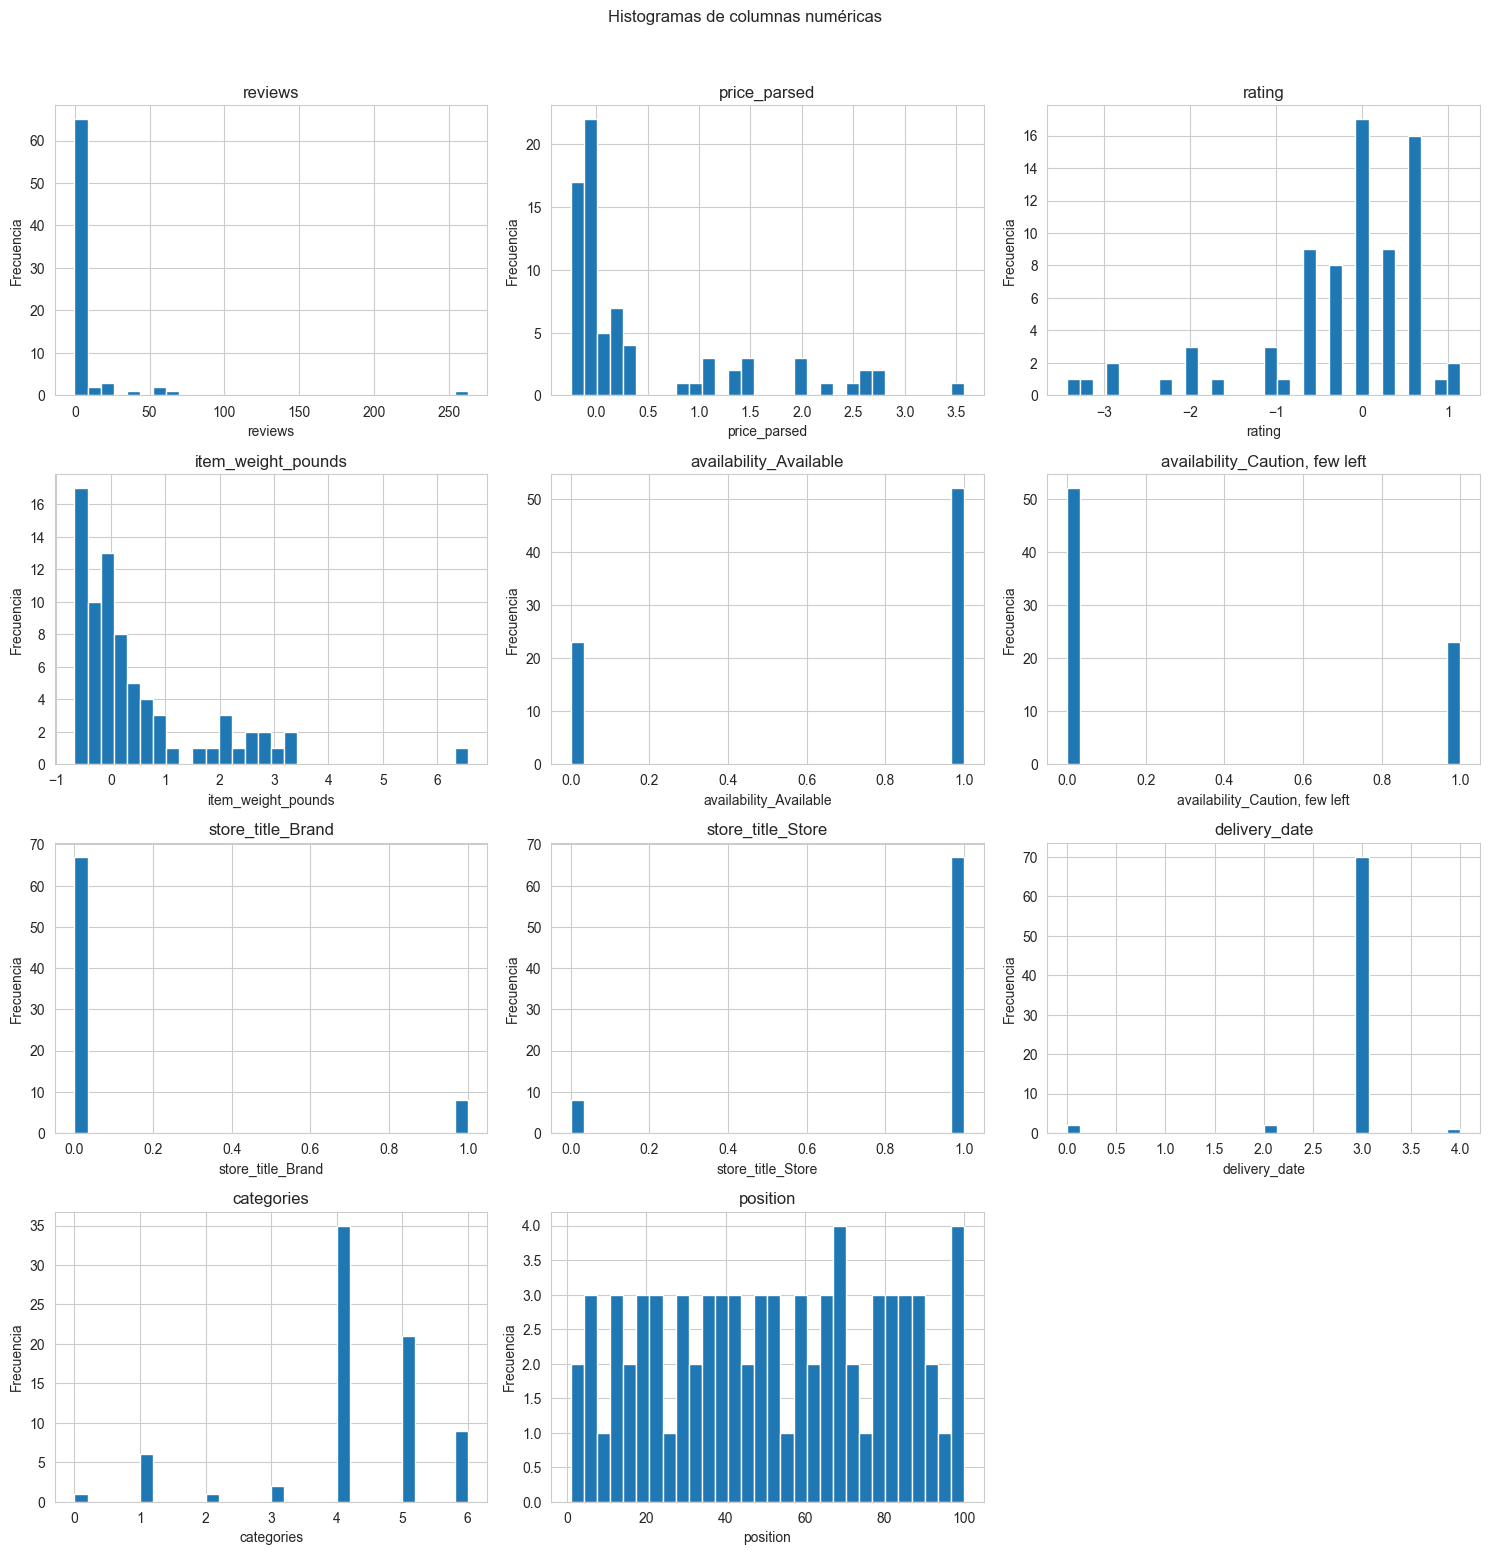

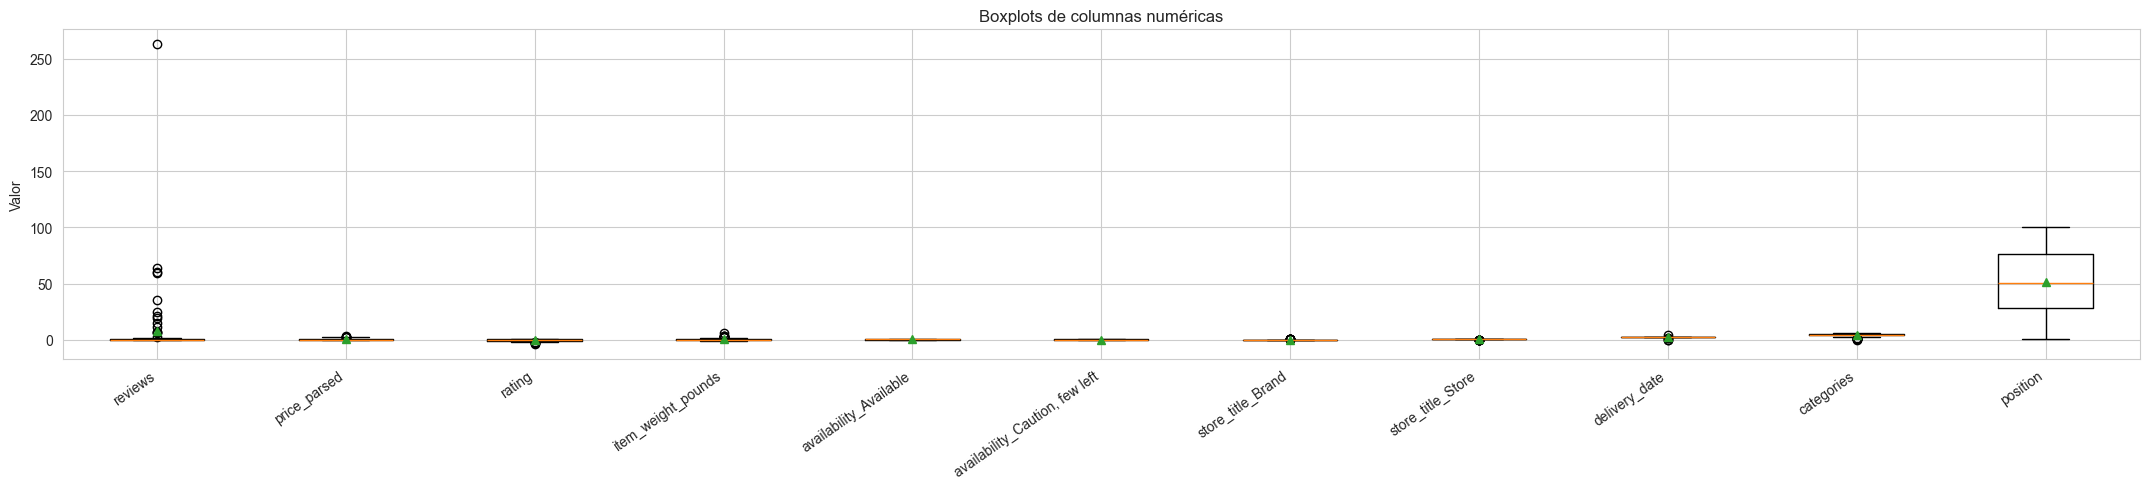

In [20]:
# Separamos las columnas númericas
num_cols = X_train_proc_df.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas numéricas:", num_cols)

# Funciones auxiliares
# Detection de outliers
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    number_outlier_detected = int(((s < lim_inf) | (s > lim_sup)).sum())
    proportion_outliers_respect_total = number_outlier_detected / len(s)

    return number_outlier_detected, proportion_outliers_respect_total, q1, q3, lim_inf, lim_sup

# Detecta si parece estar acotada en [0,1] o [0,100]
def bounded_guess(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    min_value, max_value = float(s.min()), float(s.max())
    if 0.0 <= min_value and max_value <= 1.0:
        return "[0,1]"
    if 0.0 <= min_value and max_value <= 100.0:
        return "[0,100]"
    return None

if len(num_cols) == 0:
    print("No hay columnas numéricas en X_train.")
else:
    # --------- Histogramas ----------
    n = len(num_cols)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()
    #Aplico Histograma y Box Plot a la parte de Entrenamiento
    for i, col in enumerate(num_cols):
        s = pd.to_numeric(X_train_proc_df[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")


    for j in range(len(num_cols), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("../reports/histogramas_numericas_procesados.png", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # --------- BOXPLOTS ----------
    series_pairs = []
    for c in num_cols:
        v = pd.to_numeric(X_train_proc_df[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("../reports/boxplots_numericas_procesados.png", dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig2)

In [21]:
X_train_proc_df.corr()

,reviews,price_parsed,rating,item_weight_pounds,availability_Available,"availability_Caution, few left",store_title_Brand,store_title_Store,delivery_date,categories,position
reviews,1.000000,-0.023010,0.193747,-0.162037,0.089573,-0.089573,-0.075397,0.075397,-0.010196,-0.279359,-0.030350
price_parsed,-0.023010,1.000000,-0.089218,0.601227,-0.358040,0.358040,-0.215105,0.215105,-0.341813,-0.214975,-0.739842
rating,0.193747,-0.089218,1.000000,-0.100160,0.182437,-0.182437,0.027269,-0.027269,-0.114834,0.168135,-0.001572
item_weight_pounds,-0.162037,0.601227,-0.100160,1.000000,-0.272111,0.272111,-0.058348,0.058348,-0.200957,-0.041671,-0.380085
availability_Available,0.089573,-0.358040,0.182437,-0.272111,1.000000,-1.000000,0.042465,-0.042465,0.269438,0.218711,0.283917
"availability_Caution, few left",-0.089573,0.358040,-0.182437,0.272111,-1.000000,1.000000,-0.042465,0.042465,-0.269438,-0.218711,-0.283917
store_title_Brand,-0.075397,-0.215105,0.027269,-0.058348,0.042465,-0.042465,1.000000,-1.000000,0.061920,0.183634,0.265856
store_title_Store,0.075397,0.215105,-0.027269,0.058348,-0.042465,0.042465,-1.000000,1.000000,-0.061920,-0.183634,-0.265856
delivery_date,-0.010196,-0.341813,-0.114834,-0.200957,0.269438,-0.269438,0.061920,-0.061920,1.000000,0.023524,0.262407
categories,-0.279359,-0.214975,0.168135,-0.041671,0.218711,-0.218711,0.183634,-0.183634,0.023524,1.000000,0.247694
